# Unsupervised.ipynb
Original code by Allen Chezick - PCA and KMeans on cleaned pkl

In [1]:
#KMeans run with ncomponents = 0.95
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import VarianceThreshold
from datetime import date
from pathlib import Path

#file paths
clean_path = "/voc/work/GitHub Submission Milestone II/Outputs/final_pkl/df_best.pkl"
out_dir = Path("/voc/work/GitHub Submission Milestone II/Outputs/unsupervised_outputs")
out_dir.mkdir(parents=True, exist_ok=True)

#load data
df = pd.read_pickle(clean_path)
print(f"Loaded dataset: {df.shape}")

#make model ready, remove outcome/general/mortality cols before PCA
def make_model_ready(df):
    """Removes outcome, general, and mortality columns before PCA."""
    all_cols = df.columns.tolist()
    mortality_cols = [c for c in all_cols if c.startswith('mortality_')]
    outcome_cols = [c for c in all_cols if c.startswith('deterioration_')]
    general_cols = [c for c in all_cols if c.startswith('general_')]
    to_remove = [
        'target','Unnamed:0','clinical_deterioration_any','death_or_deterioration_any',
        'general_subject_id','mortality_category','Alive','Short-term','Medium-term',
        'Long-term','organ_support','mortality_class','support_mortality_combo',
        'shortterm_death_or_deterioration','admit','month_time','tod_time'
    ]
    
    fit_cols = [c for c in all_cols if c not in set(outcome_cols + mortality_cols + general_cols + to_remove)]
    X_fit = df[fit_cols].select_dtypes(include=["number", "bool", "int64", "float64"]).fillna(df[fit_cols].median())
    print(f"Numeric columns kept for PCA: {len(fit_cols)}")
    print(f"First few fit columns: {fit_cols[:10]}")
    return X_fit, fit_cols

X_fit, fit_cols = make_model_ready(df)

#scale and remove low variance columns
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_fit)

vt = VarianceThreshold(threshold=1e-5)
X_vt = vt.fit_transform(X_scaled)
print(f"After variance trimming: {X_vt.shape[1]} features kept")

#PCA transformation
pca = PCA(n_components=0.95, random_state=0)
Z = pca.fit_transform(X_vt)

print(f"PCs kept: {pca.n_components_}")
print(f"Explained variance: {round(pca.explained_variance_ratio_.sum(), 3)}")

#store PCA scores
today = str(date.today()).replace("-", "_")
pc_df = pd.DataFrame(Z, index=df.index).add_prefix("PC_")
pc_df.to_csv(out_dir / f"pca_scores_{today}.csv", index=True)
print("Saved PCA scores")

#KMeans sweep, show progress and best results
print("KMeans sweep starting...")
best_k, best_s, best_model = None, -1, None
for k in range(3, 11):
    print(f"Running KMeans for k={k}...")
    km = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(Z)
    s = silhouette_score(Z, km.labels_)
    print(f"   silhouette={round(s, 3)}")
    if s > best_s:
        best_k, best_s, best_model = k, s, km
print(f"Best result: k={best_k}, silhouette={round(best_s, 3)}")

#determine clusters
df_clusters = df.assign(cluster=best_model.labels_)
df_clusters.to_csv(out_dir / f"clusters_{today}.csv", index=False)

#enrichment summary
outcome_cols = [c for c in df.columns if c.startswith("deterioration_")]
if outcome_cols:
    summary = df_clusters.groupby("cluster")[outcome_cols].mean()
    summary.to_csv(out_dir / f"cluster_enrichment_{today}.csv")
    print("enrichment summary stored")

Loaded dataset: (116609, 166)
Numeric columns kept for PCA: 133
First few fit columns: ['demographics_gender', 'demographics_age', 'demographics_ethnicity_asian', 'demographics_ethnicity_black/african', 'demographics_ethnicity_hispanic/latino', 'demographics_ethnicity_other', 'demographics_ethnicity_white', 'biometrics_bmi', 'biometrics_weight', 'biometrics_height']
After variance trimming: 127 features kept
PCs kept: 3
Explained variance: 0.961
Saved PCA scores
KMeans sweep starting...
Running KMeans for k=3...
   silhouette=0.93
Running KMeans for k=4...
   silhouette=0.926
Running KMeans for k=5...
   silhouette=0.884
Running KMeans for k=6...
   silhouette=0.875
Running KMeans for k=7...
   silhouette=0.851
Running KMeans for k=8...
   silhouette=0.851
Running KMeans for k=9...
   silhouette=0.853
Running KMeans for k=10...
   silhouette=0.83
Best result: k=3, silhouette=0.93
enrichment summary stored


# Results of Unsupervised Component with Visualizations
Original code by Hunter Belous - The following visualizations summarize PCA results, clustering structure, and feature enrichment
to interpret unsupervised findings.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D

#file paths
out_dir = Path("/voc/work/GitHub Submission Milestone II/Outputs/unsupervised_outputs")
pca_path = sorted(out_dir.glob("pca_scores_*.csv"))[-1]
cluster_path = sorted(out_dir.glob("clusters_*.csv"))[-1]
enrich_path = sorted(out_dir.glob("cluster_enrichment_*.csv"))[-1]

#load the data in
pca_df = pd.read_csv(pca_path, index_col=0)
clusters_df = pd.read_csv(cluster_path)
enrich_df = pd.read_csv(enrich_path)

print(f"PCA: {pca_df.shape}, Clusters: {clusters_df.shape}")

#in the PCA space, include the clusters
if "cluster" not in pca_df.columns:
    pca_df = pca_df.join(clusters_df["cluster"])

PCA: (116609, 3), Clusters: (116609, 167)


# 2D PCA Cluster Plot
This visualization shows each dot as one patient, and clusters are identified by color. The KMeans model found meaningful groupings indicated by the separation of the clusters. The three clusters represent differnent potential physiological profiles

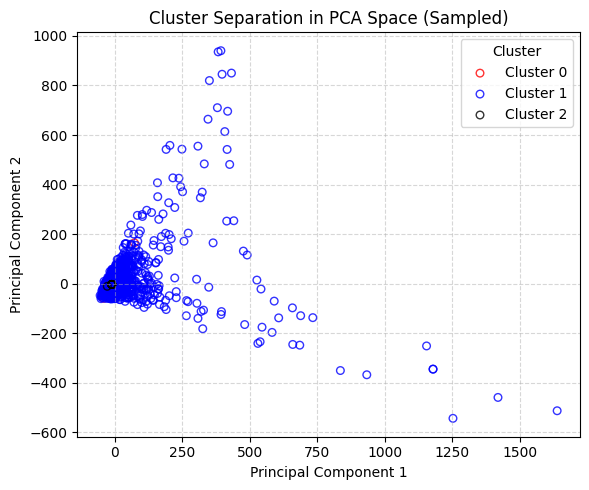

In [12]:
#2D PCA Scatterplot
sample_idx = pca_df.sample(n=min(5000, len(pca_df)), random_state=0).index
sample = pca_df.loc[sample_idx]

#color coordination
colors = ["red", "blue", "black"]

plt.figure(figsize=(6, 5))

for i, color in enumerate(colors):
    cluster_data = sample[sample["cluster"] == i]
    plt.scatter(
        cluster_data["PC_0"],
        cluster_data["PC_1"],
        facecolors='none',  # hollow points
        edgecolors=color,
        label=f"Cluster {i}",
        alpha=0.8,
        s=30
    )

plt.title("Cluster Separation in PCA Space (Sampled)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Cluster", loc="upper right", frameon=True)
plt.tight_layout()
plt.show()

# 3D PCA Cluster Plot
This visualization shows the third principal component, allowing to add a bit more depth with some overlap to show clustering shape remains consistent and no major mixing is detected.

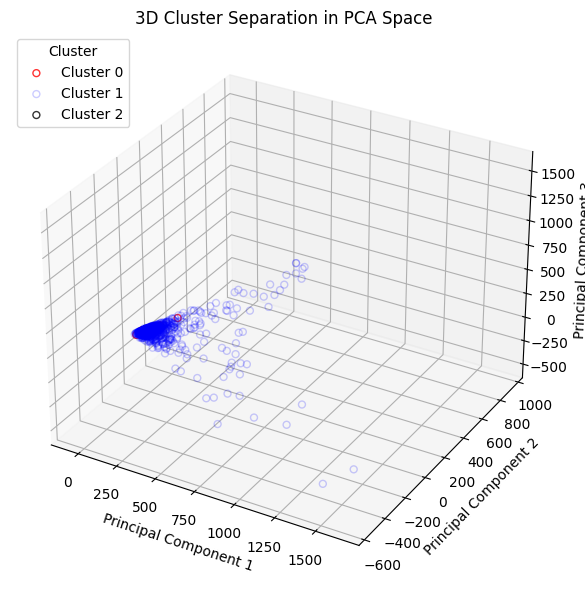

In [13]:
#3D PCA scatterplot
from mpl_toolkits.mplot3d import Axes3D

if "PC_2" in pca_df.columns:
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')

    #color coordination
    colors = ["red", "blue", "black"]

    for i, color in enumerate(colors):
        cluster_data = sample[sample["cluster"] == i]
        alpha_val = 0.2 if color == "blue" else 0.8
        ax.scatter(
            cluster_data["PC_0"],
            cluster_data["PC_1"],
            cluster_data["PC_2"],
            facecolors='none',   
            edgecolors=color,
            label=f"Cluster {i}",
            alpha=alpha_val,
            s=25
        )

    ax.set_title("3D Cluster Separation in PCA Space")
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")
    ax.legend(title="Cluster", loc="upper left")
    plt.tight_layout()
    plt.show()

# Death or Deterioration 2D PCA Cluster Plot
This visualization shows the 2D version of the cluster plot, but color is representative of patient outcome (red is death or deterioration). If red shows up dominantly in a cluster, the cluster could display higher risk of death or deterioration. 

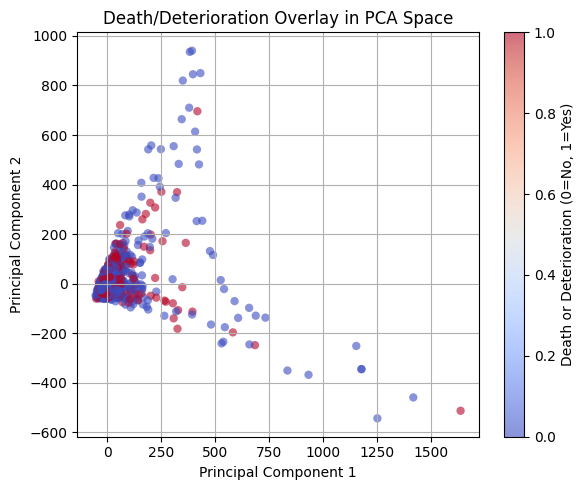

In [14]:
#death or deterioration any overlayed with clustering
if "death_or_deterioration_any" in clusters_df.columns:
    merged = pca_df.join(clusters_df["death_or_deterioration_any"], how="left")
    merged_sample = merged.loc[sample_idx]
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(
        merged_sample["PC_0"],
        merged_sample["PC_1"],
        c=merged_sample["death_or_deterioration_any"],
        cmap="coolwarm",
        alpha=0.6,
        edgecolor="none"
    )
    plt.colorbar(scatter, label="Death or Deterioration (0=No, 1=Yes)")
    plt.title("Death/Deterioration Overlay in PCA Space")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# KMeans Silhouette Score
This visualization shows the full range of the output KMeans sweep, showing each silhouette score. The best of the Kmeans was reported as k=3.

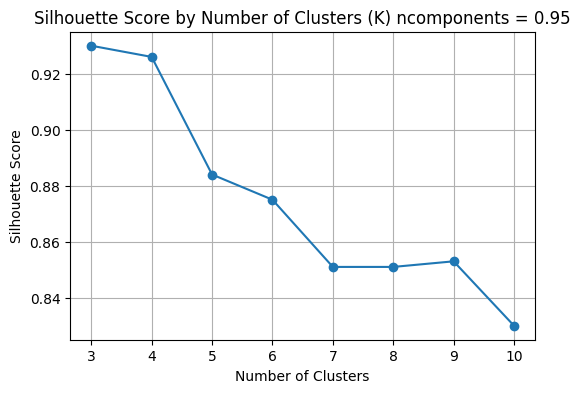

In [4]:
#silhouette score plot, sensitivity of ncomponents = 0.95
k_values = list(range(3, 11))
sil_values = [0.93, 0.926, 0.884, 0.875, 0.851, 0.851, 0.853, 0.83] #this is stored from the results of the Kmeans output to avoid rerunning. Reference above for more info. 

plt.figure(figsize=(6, 4))
plt.plot(k_values, sil_values, marker='o')
plt.title("Silhouette Score by Number of Clusters (K) ncomponents = 0.95")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [1]:
#Kmeans run with ncomponents = 30
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import VarianceThreshold
from datetime import date
from pathlib import Path

#file paths
clean_path = "/voc/work/GitHub Submission Milestone II/Outputs/final_pkl/df_best.pkl"
out_dir = Path("/voc/work/GitHub Submission Milestone II/Outputs/unsupervised_outputs")
out_dir.mkdir(parents=True, exist_ok=True)

#load data
df = pd.read_pickle(clean_path)
print(f"Loaded dataset: {df.shape}")

#make model ready, remove outcome/general/mortality cols before PCA
def make_model_ready(df):
    """Removes outcome, general, and mortality columns before PCA."""
    all_cols = df.columns.tolist()
    mortality_cols = [c for c in all_cols if c.startswith('mortality_')]
    outcome_cols = [c for c in all_cols if c.startswith('deterioration_')]
    general_cols = [c for c in all_cols if c.startswith('general_')]
    to_remove = [
        'target','Unnamed:0','clinical_deterioration_any','death_or_deterioration_any',
        'general_subject_id','mortality_category','Alive','Short-term','Medium-term',
        'Long-term','organ_support','mortality_class','support_mortality_combo',
        'shortterm_death_or_deterioration','admit','month_time','tod_time'
    ]
    
    fit_cols = [c for c in all_cols if c not in set(outcome_cols + mortality_cols + general_cols + to_remove)]
    X_fit = df[fit_cols].select_dtypes(include=["number", "bool", "int64", "float64"]).fillna(df[fit_cols].median())
    print(f"Numeric columns kept for PCA: {len(fit_cols)}")
    print(f"First few fit columns: {fit_cols[:10]}")
    return X_fit, fit_cols

X_fit, fit_cols = make_model_ready(df)

#scale and remove low variance columns
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_fit)

vt = VarianceThreshold(threshold=1e-5)
X_vt = vt.fit_transform(X_scaled)
print(f"After variance trimming: {X_vt.shape[1]} features kept")

#PCA transformation
pca = PCA(n_components=30, random_state=0)
Z = pca.fit_transform(X_vt)

print(f"PCs kept: {pca.n_components_}")
print(f"Explained variance: {round(pca.explained_variance_ratio_.sum(), 3)}")

#store PCA scores
today = str(date.today()).replace("-", "_")
pc_df = pd.DataFrame(Z, index=df.index).add_prefix("PC_")
pc_df.to_csv(out_dir / f"pca_scores_{today}.csv", index=True)
print("Saved PCA scores")

#KMeans sweep, show progress and best results
print("KMeans sweep starting...")
best_k, best_s, best_model = None, -1, None
for k in range(3, 11):
    print(f"Running KMeans for k={k}...")
    km = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(Z)
    s = silhouette_score(Z, km.labels_)
    print(f"   silhouette={round(s, 3)}")
    if s > best_s:
        best_k, best_s, best_model = k, s, km
print(f"Best result: k={best_k}, silhouette={round(best_s, 3)}")

#determine clusters
df_clusters = df.assign(cluster=best_model.labels_)
df_clusters.to_csv(out_dir / f"clusters_{today}.csv", index=False)

#enrichment summary
outcome_cols = [c for c in df.columns if c.startswith("deterioration_")]
if outcome_cols:
    summary = df_clusters.groupby("cluster")[outcome_cols].mean()
    summary.to_csv(out_dir / f"cluster_enrichment_{today}.csv")
    print("enrichment summary stored")

Loaded dataset: (116609, 166)
Numeric columns kept for PCA: 133
First few fit columns: ['demographics_gender', 'demographics_age', 'demographics_ethnicity_asian', 'demographics_ethnicity_black/african', 'demographics_ethnicity_hispanic/latino', 'demographics_ethnicity_other', 'demographics_ethnicity_white', 'biometrics_bmi', 'biometrics_weight', 'biometrics_height']
After variance trimming: 127 features kept
PCs kept: 30
Explained variance: 0.999
Saved PCA scores
KMeans sweep starting...
Running KMeans for k=3...
   silhouette=0.898
Running KMeans for k=4...
   silhouette=0.888
Running KMeans for k=5...
   silhouette=0.807
Running KMeans for k=6...
   silhouette=0.789
Running KMeans for k=7...
   silhouette=0.734
Running KMeans for k=8...
   silhouette=0.736
Running KMeans for k=9...
   silhouette=0.749
Running KMeans for k=10...
   silhouette=0.683
Best result: k=3, silhouette=0.898
enrichment summary stored


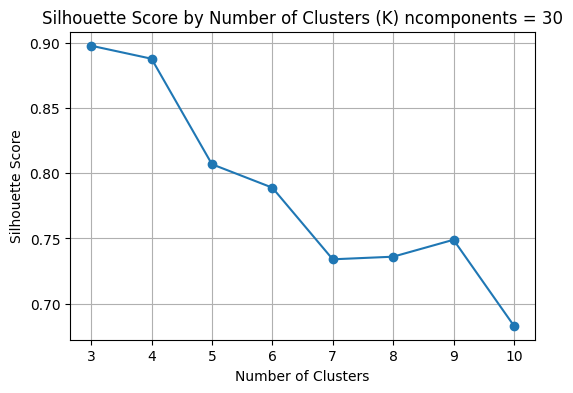

In [3]:
import matplotlib.pyplot as plt
#silhouette score plot, sensitivity of ncomponents = 0.30
k_values = list(range(3, 11))
sil_values = [0.898, 0.888, 0.807, 0.789, 0.734, 0.736, 0.749, 0.683] #this is stored from the results of the Kmeans output to avoid rerunning. Reference above for more info. 

plt.figure(figsize=(6, 4))
plt.plot(k_values, sil_values, marker='o')
plt.title("Silhouette Score by Number of Clusters (K) ncomponents = 30")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()